# Time Series Forcasting with a Linear Regression Model

In [151]:
import pandas as pd
with open("../data/current_measurements.json") as file:
    df = pd.read_json(file)

In [152]:
df = df.iloc[::-1] # reverse the order, the data was ordered by DATE DESC, but we want the more recent data to be used in the test set
df['measuredAt'] = pd.to_datetime(df['measuredAt'])
df.index = df['measuredAt']
del(df['measuredAt'])

In [153]:
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

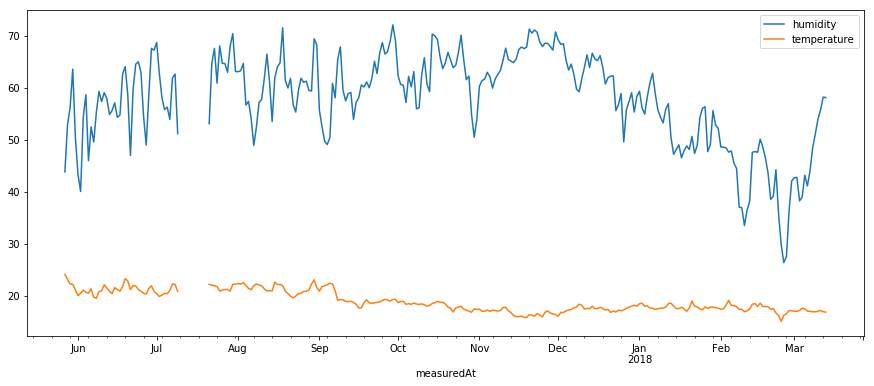

In [154]:
df.resample('D').mean().plot()

In [155]:
df.index

DatetimeIndex(['2017-05-27 16:11:57.235106', '2017-05-27 17:19:42.369249',
               '2017-05-27 17:23:30.756653', '2017-05-27 18:00:17.092384',
               '2017-05-27 18:35:47.109730', '2017-05-27 18:40:53.500771',
               '2017-05-27 19:00:13.771968', '2017-05-27 20:00:10.138441',
               '2017-05-27 21:00:09.525139', '2017-05-27 22:00:40.576659',
               ...
               '2018-03-12 23:00:07.112420', '2018-03-13 00:00:09.169142',
               '2018-03-13 01:00:09.115133', '2018-03-13 02:00:10.630028',
               '2018-03-13 03:00:17.808363', '2018-03-13 04:00:08.789151',
               '2018-03-13 05:00:07.103134', '2018-03-13 06:00:07.075913',
               '2018-03-13 07:00:09.574287', '2018-03-13 08:00:12.056965'],
              dtype='datetime64[ns]', name='measuredAt', length=6626, freq=None)

## building a training and test set

In [156]:
test_size = 0.2
lookback = 24

In [157]:
import numpy as np
dataset = df.humidity.values

In [158]:
X, y = [], []
for i in range(lookback, len(dataset) - lookback):
    X.append(dataset[i-lookback:i])
    y.append(dataset[i:i+lookback])


In [159]:
# split into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

## Training the model

In [160]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [161]:
predicted_train = lin_reg.predict(X_train)
predicted_test = lin_reg.predict(X_test)

## Evaluating the results

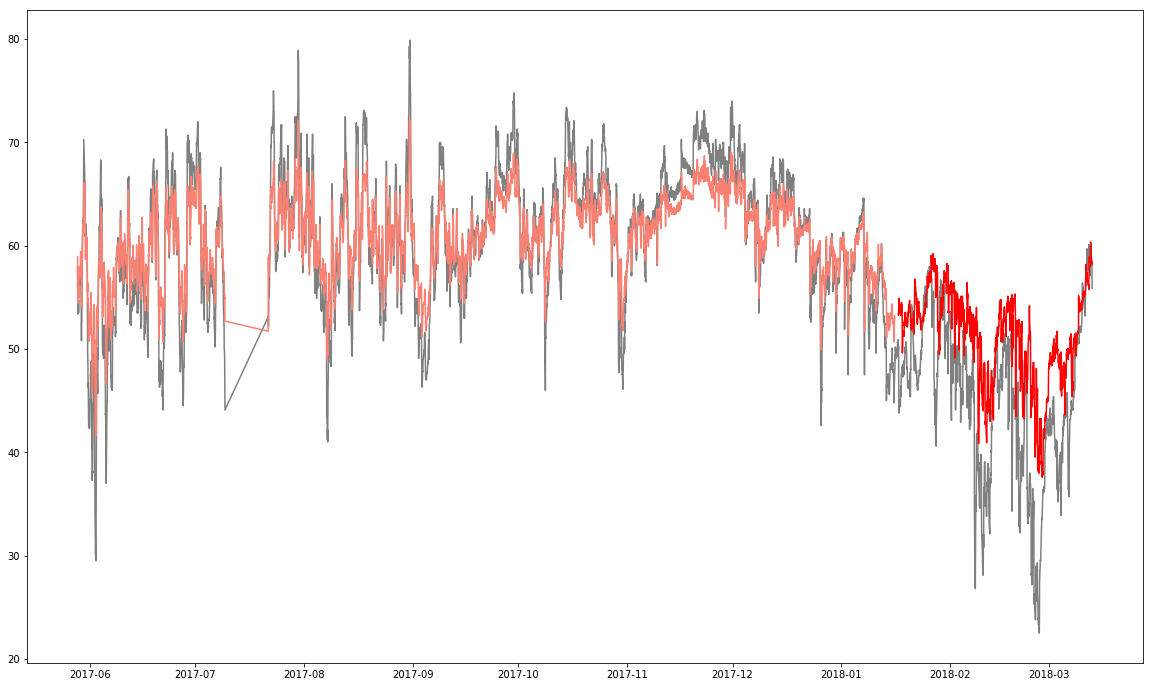

In [168]:
predicted_train_plot = []
for i in range(0, predicted_train.shape[0]):
    predicted_train_plot = np.append(predicted_train_plot, predicted_train[i, -1])
    
predicted_test_plot = []
for i in range(0, predicted_test.shape[0]):
    predicted_test_plot = np.append(predicted_test_plot, predicted_test[i, -1])

plt.figure(figsize=(20,12))
plt.plot(df.index[lookback:], df.humidity[lookback:], color="gray")
plt.plot(df.index[lookback:len(predicted_train_plot) + lookback], predicted_train_plot, color="salmon")
plt.plot(df.index[lookback * 2 + len(predicted_train_plot):len(predicted_test_plot) + lookback * 2 + len(predicted_train_plot)], predicted_test_plot, color="red")

In [163]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

train_rmse = math.sqrt(mean_squared_error(y_train, predicted_train))
test_rmse = math.sqrt(mean_squared_error(y_test, predicted_test))

print("RMSE on training set %.6f" % train_rmse)
print("RMSE on test set %.6f" % test_rmse)


print("MAE on training set %.6f" % mean_absolute_error(y_train, predicted_train))
print("MAE on test set %.6f" % mean_absolute_error(y_test, predicted_test))

RMSE on training set 4.296711
RMSE on test set 5.815275
MAE on training set 3.045341
MAE on test set 4.162518
